## Doniyor Nimatullo
### Tensorflow Core Tutorials - Image Classification

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
import pathlib

Download flowers dataset

In [20]:
DATASET_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

In [21]:
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=DATASET_URL, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [22]:
print(len(list(data_dir.glob('*/*.jpg'))))

3670


Load images off disk into a Dataset object

In [23]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of images for training, 20% for validation

In [24]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [25]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Possible class names in dataset

In [26]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


Visualizing data:

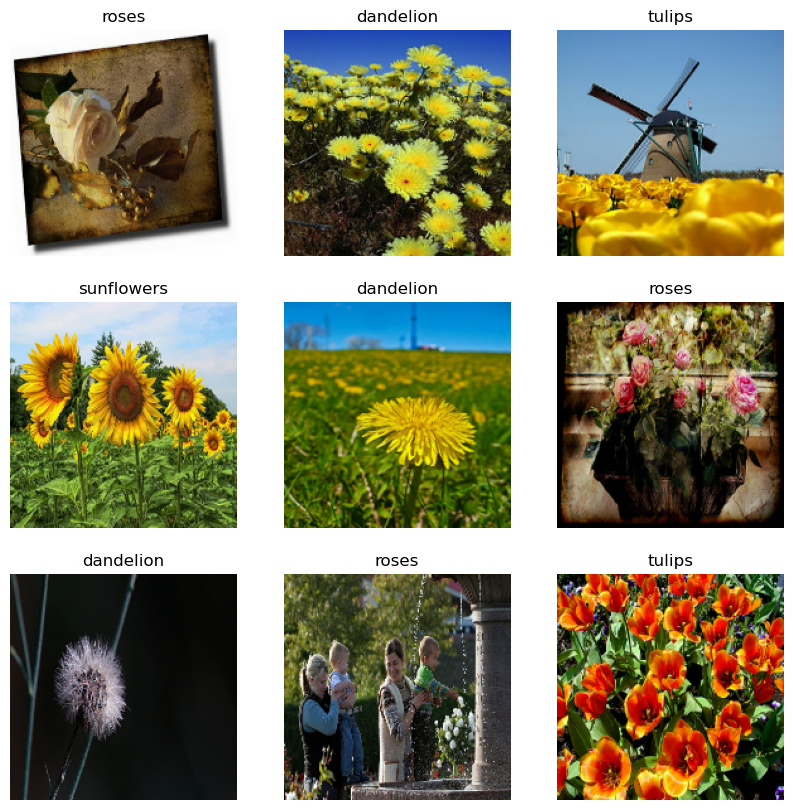

In [27]:
plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [29]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Now to construct the model

In [30]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [32]:
model.compile(optimizer='adam',
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [12]:
print("Num GPUs available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 1


In [33]:
epochs=10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10


92/92 [==============================] - 6s 50ms/step - loss: 1.4615 - accuracy: 0.4019 - val_loss: 1.0690 - val_accuracy: 0.5722
Epoch 2/10
92/92 [==============================] - 5s 51ms/step - loss: 1.0152 - accuracy: 0.6001 - val_loss: 0.9884 - val_accuracy: 0.6294
Epoch 3/10
92/92 [==============================] - 4s 48ms/step - loss: 0.8526 - accuracy: 0.6781 - val_loss: 0.9921 - val_accuracy: 0.6022
Epoch 4/10
92/92 [==============================] - 5s 49ms/step - loss: 0.6804 - accuracy: 0.7534 - val_loss: 1.2882 - val_accuracy: 0.5749
Epoch 5/10
92/92 [==============================] - 5s 51ms/step - loss: 0.6216 - accuracy: 0.7820 - val_loss: 1.4295 - val_accuracy: 0.5995
Epoch 6/10
92/92 [==============================] - 5s 51ms/step - loss: 0.4740 - accuracy: 0.8389 - val_loss: 1.8919 - val_accuracy: 0.5599
Epoch 7/10
92/92 [==============================] - 5s 51ms/step - loss: 0.3755 - accuracy: 0.8655 - val_loss: 1.7029 - val_accuracy: 0.6213
Epoch 8/10
92/92 [======

Visualizing our model's accuracy

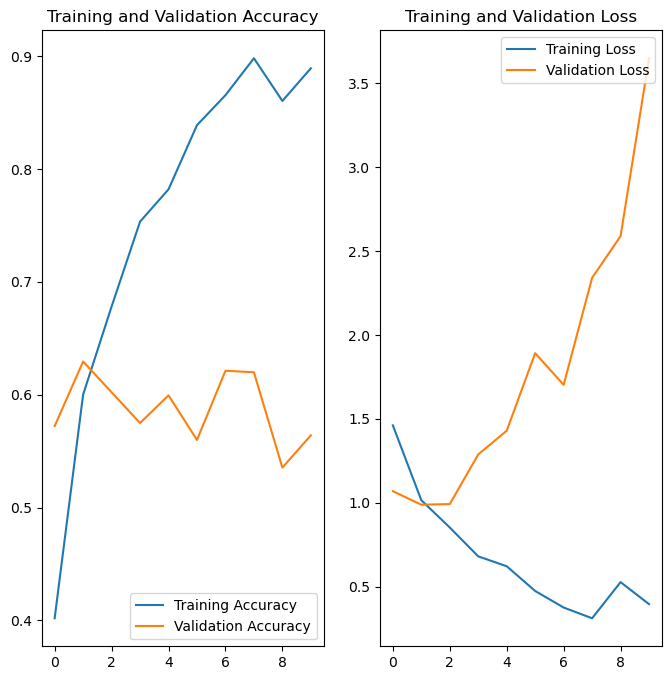

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


After this first pass, the accuracy is only around 60%.

To avoid overfitting, we can use data augmentation and dropout to prevent the model from fitting too close to the training data

In [35]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)


Visualize the augmentation

2023-11-28 15:16:30.798362: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 15:16:30.948583: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 15:16:31.012610: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 15:16:31.070300: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 15:16:31.136084: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2023-11-28 15:16:31.190678: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

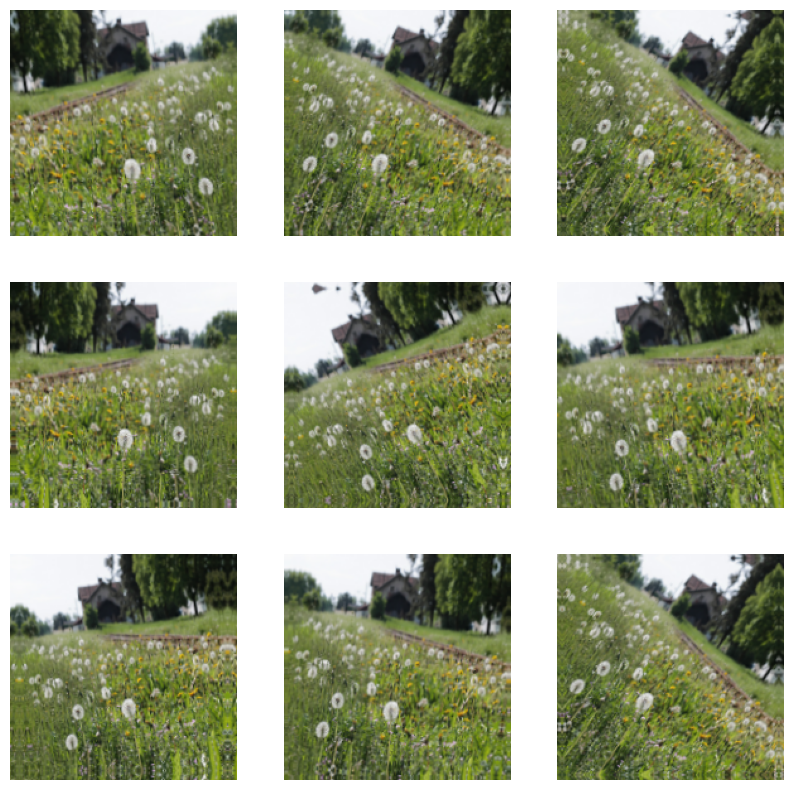

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


In [44]:
model = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/15
92/92 [==============================] - 5s 49ms/step - loss: 1.6940 - accuracy: 0.3099 - val_loss: 1.3467 - val_accuracy: 0.3828
Epoch 2/15
92/92 [==============================] - 4s 40ms/step - loss: 1.2438 - accuracy: 0.4700 - val_loss: 1.2680 - val_accuracy: 0.5136
Epoch 3/15
92/92 [==============================] - 3s 38ms/step - loss: 1.0711 - accuracy: 0.5800 - val_loss: 1.0550 - val_accuracy: 0.5763
Epoch 4/15
92/92 [==============================] - 4s 40ms/step - loss: 0.8887 - accuracy: 0.6723 - val_loss: 1.0723 - val_accuracy: 0.5940
Epoch 5/15
92/92 [==============================] - 4s 42ms/step - loss: 0.7828 - accuracy: 0.7132 - val_loss: 0.9988 - val_accuracy: 0.6213
Epoch 6/15
92/92 [==============================] - 4s 43ms/step - loss: 0.6513 - accuracy: 0.7636 - val_loss: 1.2527 - val_accuracy: 0.5858
Epoch 7/15
92/92 [==============================] - 4s 41ms/step - loss: 0.6037 - accuracy: 0.7936 - val_loss: 1.5029 - val_accuracy: 0.6008
Epoch 8/15
92

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [40]:
epochs = 15


In [ ]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Visualize performance after dropout + data augmentation

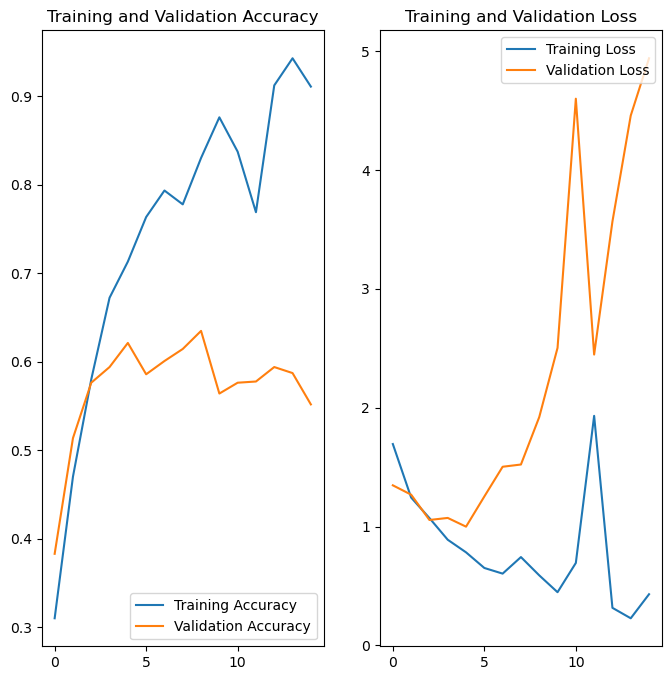

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
